<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Object Detection using IceVision

![](https://raw.githubusercontent.com/airctic/icevision/master/images/fridge-objects.png)

## Introduction
IceVision is a Framework for object detection and deep learning that makes it easier to prepare data, train an object detection model, and use that model for inference.

The IceVision Framework provides a layer across multiple deep learning engines, libraries, models, and data sets.

It enables you to work with multiple training engines, including [fastai](https://github.com/fastai/fastai), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).

It enables you to work with some of the best deep learning libraries including [mmdetection](https://arxiv.org/abs/1906.07155), [Ross Wightman's efficientdet implementation](https://github.com/rwightman/efficientdet-pytorch) and model library, [torchvision](https://pytorch.org/vision/stable/index.html), and [ultralytics Yolo](https://github.com/ultralytics/yolov5).

It enables you to select from many possible models and backbones from these libraries.

IceVision lets you switch between them with ease. This means that you can pick the engine, library, model, and data format that work for you now and easily change them in the future. You can experiment with with them to see which ones meet your requirements.

In this tutorial, you will learn how to  
1. Install IceVision. This will include the IceData package that provides easy access to several sample datasets, as well as the engines and libraries that IceVision works with.  
2. Download and prepare a dataset to work with.  
3. Select an object detection library, model, and backbone.  
4. Instantiate the model, and then train it with both the fastai and pytorch lightning engines.  
5. And finally, use the model to identify objects in images.  

The notebook is set up so that you can easily select different libraries, models, and backbones to try.


## Install IceVision and IceData
The following downloads and runs a short shell script. The script installs IceVision, IceData, the MMDetection library, and Yolo v5 as well
as the fastai and pytorch lightning engines.

Install from pypi...

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 master

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

## Imports
All of the IceVision components can be easily imported with a single line.


In [1]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/dnth/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


### Alternative option of importing icevision

In some environments wildcard imports are not allowed (eg: Kubeflow Pipelines & distributed environment that rely on pickling). 

In that case you can call `import icevision.all as iv`  instead of `from icevision.all import *`

In that case you should reference icevision objects with the `iv.` prefix, so for instance one would do `iv.Dataset` instead of the regular approach of just doing `Dataset`, same for any other icevision object (eg: `iv.tfms.A.Adapter` instead of `tfms.A.Adapter` etc).

## Download and prepare a dataset
Now we can start by downloading the Fridge Objects dataset. This tiny dataset contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides methods to load a dataset, parse annotation files, and more.

For more information about how the fridge dataset as well as its corresponding parser, check out the [fridge folder](https://github.com/airctic/icedata/tree/master/icedata/datasets/fridge) in icedata.

In [2]:
# Download the dataset
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

## Parse the dataset

The parser loads the annotation file and parses them returning a list of training and validation records. The parser has an extensible `autofix` capability that identifies common errors in annotation files, reports, and often corrects them automatically.

The parsers support multiple formats (including VOC and COCO). You can also extend the parser for additional formats if needed.

The record is a key concept in IceVision, it holds the information about an image and its annotations. It is extensible and can support other object formats and types of annotations.


In [3]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")

In [ ]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

## Creating datasets with augmentations and transforms

Data augmentations are essential for robust training and results on many datasets and deep learning tasks. IceVision ships with the [Albumentations](https://albumentations.ai/docs/) library for defining and executing transformations, but can be extended to use others.

For this tutorial, we apply the Albumentation's default `aug_tfms` to the training set. `aug_tfms` randomly applies broadly useful transformations including rotation, cropping, horizontal flips, and more. See the Albumentations documentation to learn how to customize each transformation more fully.

The validation set is only resized (with padding).

We then create `Datasets` for both. The dataset applies the transforms to the annotations (such as bounding boxes) and images in the data records.

In [5]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [6]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Understanding the transforms

The Dataset transforms are only applied when we grab (get) an item. Several of the default `aug_tfms` have a random element to them. For example, one might perform a rotation with probability 0.5 where the angle of rotation  is randomly selected between +45 and -45 degrees.

This means that the learner sees a slightly different version of an image each time it is accessed. This effectively increases the size of the dataset and improves learning.

We can look at result of getting the 0th image from the dataset a few times and see the differences. Each time you run the next cell, you will see different results due to the random element in applying transformations.

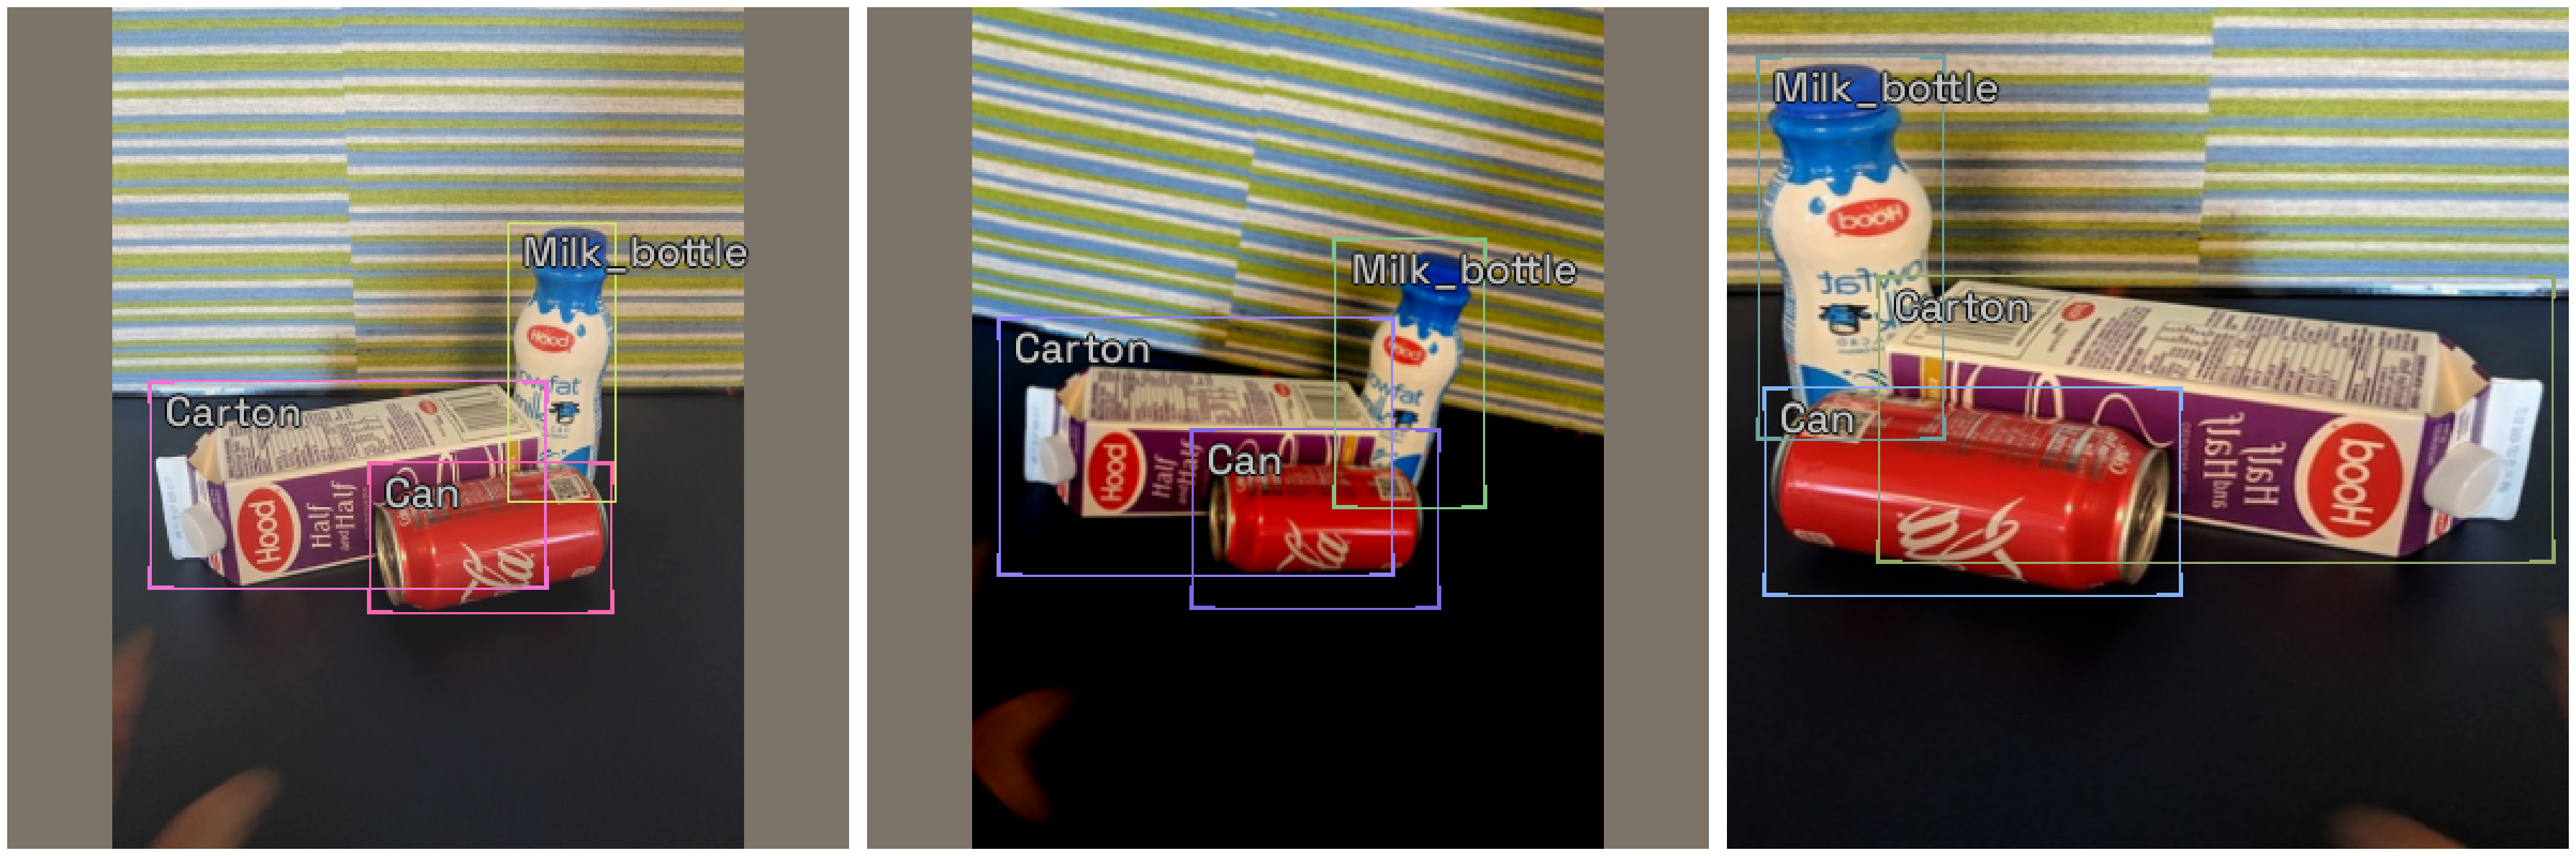

In [7]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## Select a library, model, and backbone

In order to create a model, we need to:
* Choose one of the **libraries** supported by IceVision
* Choose one of the **models** supported by the library
* Choose one of the **backbones** corresponding to a chosen model

You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.



### Creating a model
Selections only take two simple lines of code. For example, to try the mmdet library using the retinanet model and the resnet50_fpn_1x backbone  could be specified by:
```
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)
```
As pretrained models are used by default, we typically leave this out of the backbone creation step.

We've selected a few of the many options below. You can easily pick which option you want to try by setting the value of `selection`. This shows you how easy it is to try new libraries, models, and backbones.


In [ ]:
# Just change the value of selection to try another model

selection = 0

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x

if selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  # extra_args['cfg_options'] = { 
  #   'model.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 2:
  model_type = models.mmdet.faster_rcnn
  backbone = model_type.backbones.resnet101_fpn_2x
  # extra_args['cfg_options'] = { 
  #   'model.roi_head.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.roi_head.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 3:
  model_type = models.mmdet.ssd
  backbone = model_type.backbones.ssd300

if selection == 4:
  model_type = models.mmdet.yolox
  backbone = model_type.backbones.yolox_s_8x8

if selection == 5:
  model_type = models.mmdet.yolof
  backbone = model_type.backbones.yolof_r50_c5_8x8_1x_coco

if selection == 6:
  model_type = models.mmdet.detr
  backbone = model_type.backbones.r50_8x2_150e_coco

if selection == 7:
  model_type = models.mmdet.deformable_detr
  backbone = model_type.backbones.twostage_refine_r50_16x2_50e_coco

if selection == 8:
  model_type = models.mmdet.fsaf
  backbone = model_type.backbones.x101_64x4d_fpn_1x_coco

if selection == 9:
  model_type = models.mmdet.sabl
  backbone = model_type.backbones.r101_fpn_gn_2x_ms_640_800_coco

if selection == 10:
  model_type = models.mmdet.centripetalnet
  backbone = model_type.backbones.hourglass104_mstest_16x6_210e_coco

elif selection == 11:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 12:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 13:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

In [ ]:
backbone.__dict__


Now it is just a one-liner to instantiate the model. If you want to try another *option*, just edit the line at the top of the previous cell.

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

## Data Loader

The Data Loader is specific to a model_type. The job of the data loader is to get items from a dataset and batch them up in the specific format required by each model. This is why creating the data loaders is separated from creating the datasets.

We can take a look at the first batch of items from the `valid_dl`. Remember that the `valid_tfms` only resized (with padding) and normalized records, so different images, for example, are not returned each time. This is important to provide consistent validation during training.

In [11]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Metrics

The fastai and pytorch lightning engines collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

The same metrics can be used for both fastai and pytorch lightning.

In [13]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged into other DL learning engines such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  


### Training using fastai

In [14]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [ ]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [16]:
learn.fine_tune(20, 0.00158, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,4.282796,3.556162,0.000000,00:03


epoch,train_loss,valid_loss,COCOMetric,time
0,2.906284,1.651251,0.514744,00:03
1,2.120166,1.340260,0.636351,00:03
2,1.760227,1.048941,0.744560,00:03
3,1.543842,1.071704,0.850686,00:03
4,1.387548,0.964828,0.843832,00:03
5,1.284623,0.858511,0.878575,00:03
6,1.216737,0.871548,0.878225,00:03
7,1.137540,0.832400,0.880371,00:03
8,1.083292,0.753999,0.909935,00:03
9,1.021289,0.762208,0.885468,00:03


### Training using Pytorch Lightning

In [17]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)
    
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=5, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

#### Testing using Pytorch Lightning
For testing, it is recommended to use a separate test dataset that the model did not see during training but for demonstration purposes we'll re-use the validation dataset.

In [ ]:
trainer = pl.Trainer()
trainer.test(light_model, valid_dl)

## Using the model - inference and showing results

The first step in reviewing the model is to show results from the validation dataset. This is easy to do with the `show_results` function.

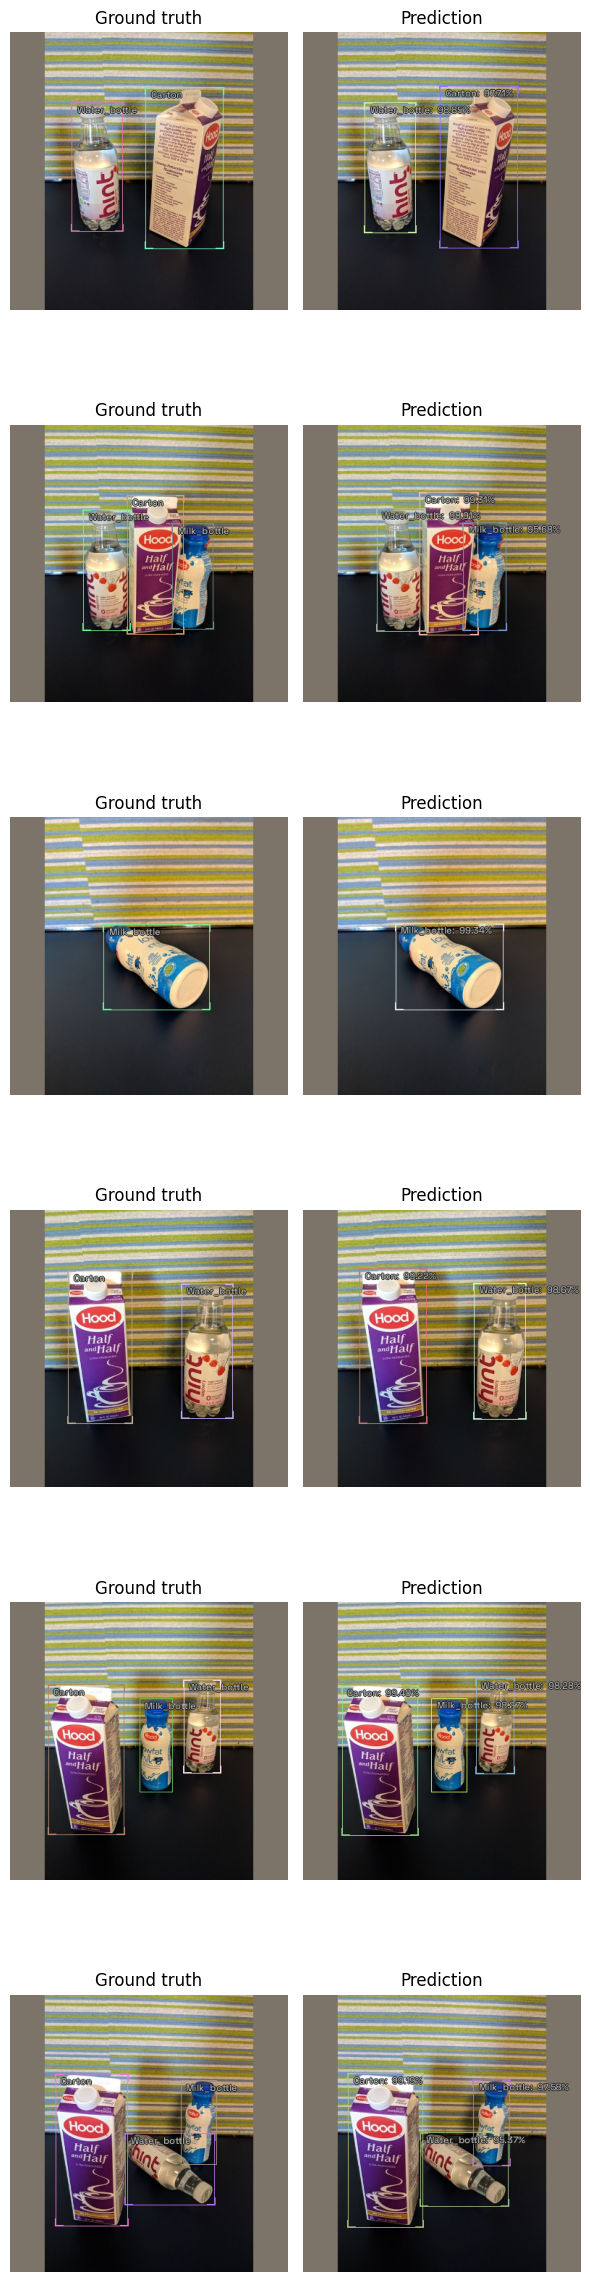

In [19]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

### Prediction

Sometimes you want to have more control than `show_results` provides. You can construct an inference dataloader using `infer_dl` from any IceVision dataset and pass this to `predict_dl` and use `show_preds` to look at the predictions.

A prediction is returned as a dict with keys: `scores`, `labels`, `bboxes`, and possibly `masks`. 

Prediction functions that take a `detection_threshold` argument will only return the predictions whose score is above the threshold.

Prediction functions that take a `keep_images` argument will only return the (tensor representation of the) image when it is `True`. In interactive environments, such as a notebook, it is helpful to see the image with bounding boxes and labels applied. In a deployment context, however, it is typically more useful (and efficient) to return the bounding boxes by themselves.



> NOTE: For a more detailed look at inference check out the [inference tutorial](https://airctic.com/dev/inference/)

In [20]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/7 [00:00<?, ?it/s]

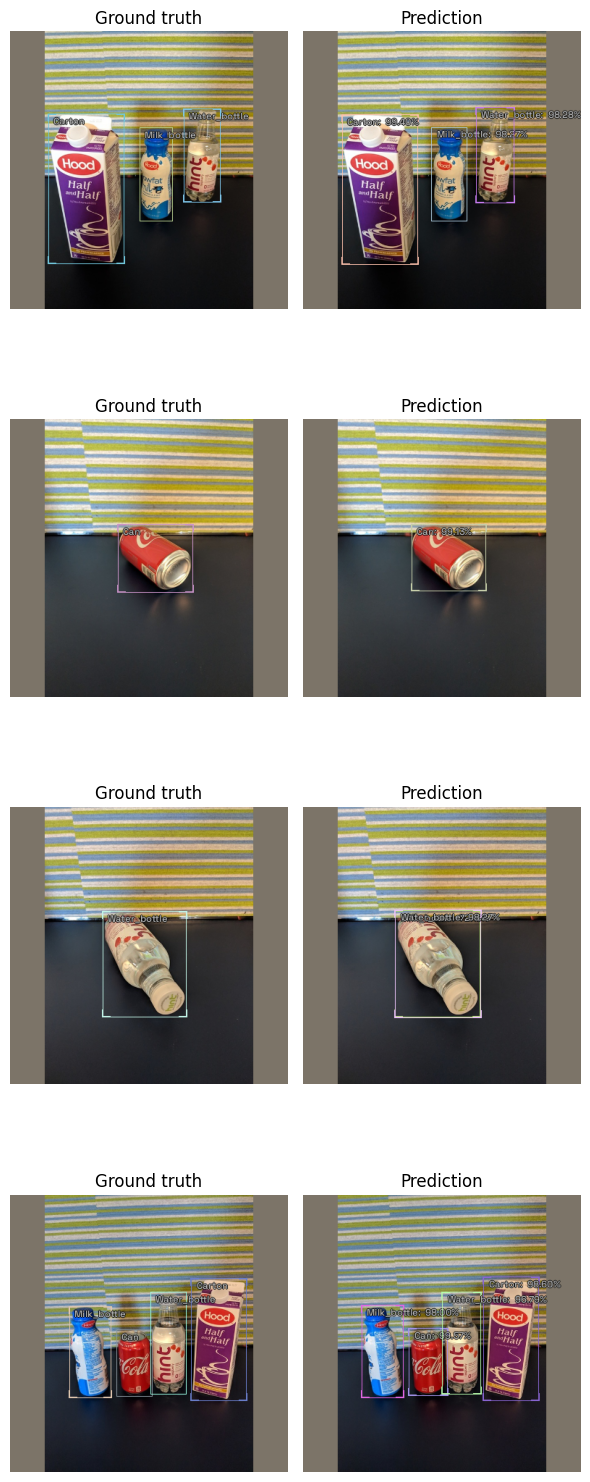

In [21]:
show_preds(preds=preds[:4])

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).